# [1] Install and Load Modules

In [1]:
# ! pip install torch-summary

In [2]:
# ! pip install timm

In [3]:
import os
import pandas as pd
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import timm

from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, datasets
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchsummary import summary

from sklearn.utils import shuffle
from PIL import Image

In [4]:
# Set a global random seed
RANDOM_SEED = 11919925
torch.manual_seed(RANDOM_SEED)

# [2] Load Pretrained Models

In [5]:
# Inception-ResnetV2
irv2 = timm.create_model('inception_resnet_v2', pretrained=True)

# MobileNetV3
mobilenetv3 = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V2)

# NASNet
nasnet = timm.create_model('nasnetalarge', pretrained=True)

# [3] Process Images 

## [3.1] Resolution and Mean/Stdev settings

Model input sizes that were originally trained on, per their original paper:

1. Inception-ResnetV2: 299x299x3, minimum 139x139x3
2. MobileNetV3: 224x224x3, minimum 32x32x3
3. NASNet: 224x224x3, minimum 32x32x3

As per information in the PyTorch documentation https://pytorch.org/vision/0.8/models.html:
- The minimum spatial dimension for each image is `224`, so this will be the value for rescaling.
- The per-channel means and standard deviations of the images correspond to those in ImageNet, so these values will be used to ensure consistency. The mean is then `[0.485, 0.456, 0.406]`, and standard deviation is `[0.229, 0.224, 0.225]`.

In [6]:
# Presets for image transformation: image resolution and mean/std for normalising

img_height, img_width = 224, 224  # Min resolution for all models

mean_imgnet = [0.485, 0.456, 0.406]  # Value taken from ImageNet
std_imgnet = [0.229, 0.224, 0.225]  # Value taken from ImageNet

This notebook is placed in the same location as the `food-101` data directory.

In [7]:
# This is the content of the food-101 data directory
data_path = "./food-101"
os.listdir(data_path)

['.DS_Store', 'images', 'meta', 'license_agreement.txt', 'README.txt']

The folder of interest is the `meta` folder, which includes information about the classes, as well as training-testing splits.

In [8]:
with open("./food-101/meta/classes.txt", "r") as file:
    labels = file.read().splitlines()

In [9]:
# Read the first 5 labels
labels[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [10]:
# Enumerate the labels to assign a numeric label to each class
labels = {value: key for key, value in enumerate(labels)}

## [3.2] Transform

The `transform` object then wraps all necessary transformation steps, which include resizing, tensor conversion, and normalisation. This object will be used later on during dataset creation.

In [11]:
transform = transforms.Compose(
    [
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_imgnet, std=std_imgnet)
    ]
)

## [3.3] Dataset creation

In [12]:
with open("./food-101/meta/train.txt", "r") as f:
    array = f.read().splitlines()
    
array[:5]

['apple_pie/1005649',
 'apple_pie/1014775',
 'apple_pie/1026328',
 'apple_pie/1028787',
 'apple_pie/1043283']

In [13]:
def create_data(path, data_path):
    """
    path: the path to the text data defining a data subset (e.g. train.txt)
    """
    
    with open(path, "r") as f:
        array = f.read().splitlines()
    
    curr_path = os.getcwd()
    img_path = f"{data_path}/images"
    full_img_path = [f"{img_path}/{img}.jpg" for img in array]
    
    img_list = [i.split('/') for i in array]

    img_list = np.array(img_list)
    
    # Convert the list into a dataframe
    img_df = pd.DataFrame(img_list[:,0], img_list[:,1], columns=['label'])
    
    img_df['path'] = full_img_path
    
    img_df = shuffle(img_df, random_state=RANDOM_SEED)
    
    return img_df

In [14]:
train_imgs = create_data('./food-101/meta/train.txt', data_path=data_path)
train_imgs.head()

label                                              path
1383119         tuna_tartare        ./food-101/images/tuna_tartare/1383119.jpg
1073049             beignets            ./food-101/images/beignets/1073049.jpg
1832589         clam_chowder        ./food-101/images/clam_chowder/1832589.jpg
822122   spaghetti_carbonara  ./food-101/images/spaghetti_carbonara/822122.jpg
1475153        chicken_wings       ./food-101/images/chicken_wings/1475153.jpg

In [15]:
test_imgs = create_data('./food-101/meta/test.txt', data_path=data_path)
test_imgs.head()

label                                          path
9160          foie_gras          ./food-101/images/foie_gras/9160.jpg
1327524       escargots       ./food-101/images/escargots/1327524.jpg
1682911  baby_back_ribs  ./food-101/images/baby_back_ribs/1682911.jpg
2906381   bread_pudding   ./food-101/images/bread_pudding/2906381.jpg
2668349     onion_rings     ./food-101/images/onion_rings/2668349.jpg

In [16]:
train_imgs['label'].value_counts()

label
tuna_tartare               750
hot_and_sour_soup          750
risotto                    750
bread_pudding              750
grilled_cheese_sandwich    750
                          ... 
takoyaki                   750
bibimbap                   750
guacamole                  750
french_fries               750
bruschetta                 750
Name: count, Length: 101, dtype: int64

In [17]:
test_imgs['label'].value_counts()

label
foie_gras               250
fish_and_chips          250
fried_rice              250
seaweed_salad           250
caesar_salad            250
                       ... 
oysters                 250
ice_cream               250
strawberry_shortcake    250
macarons                250
spring_rolls            250
Name: count, Length: 101, dtype: int64

Each set has the same number of images per label, so I'm going to perform stratified sampling on the training and testing sets, taking 10% of the dataset as a small sample to choose the best architecture.

In [18]:
# Generate training and testing samples
train_imgs_sample = train_imgs.groupby('label', group_keys=False).apply(lambda s: s.sample(frac=0.1, random_state=RANDOM_SEED))
test_imgs_sample = test_imgs.groupby('label', group_keys=False).apply(lambda s: s.sample(frac=0.1, random_state=RANDOM_SEED))

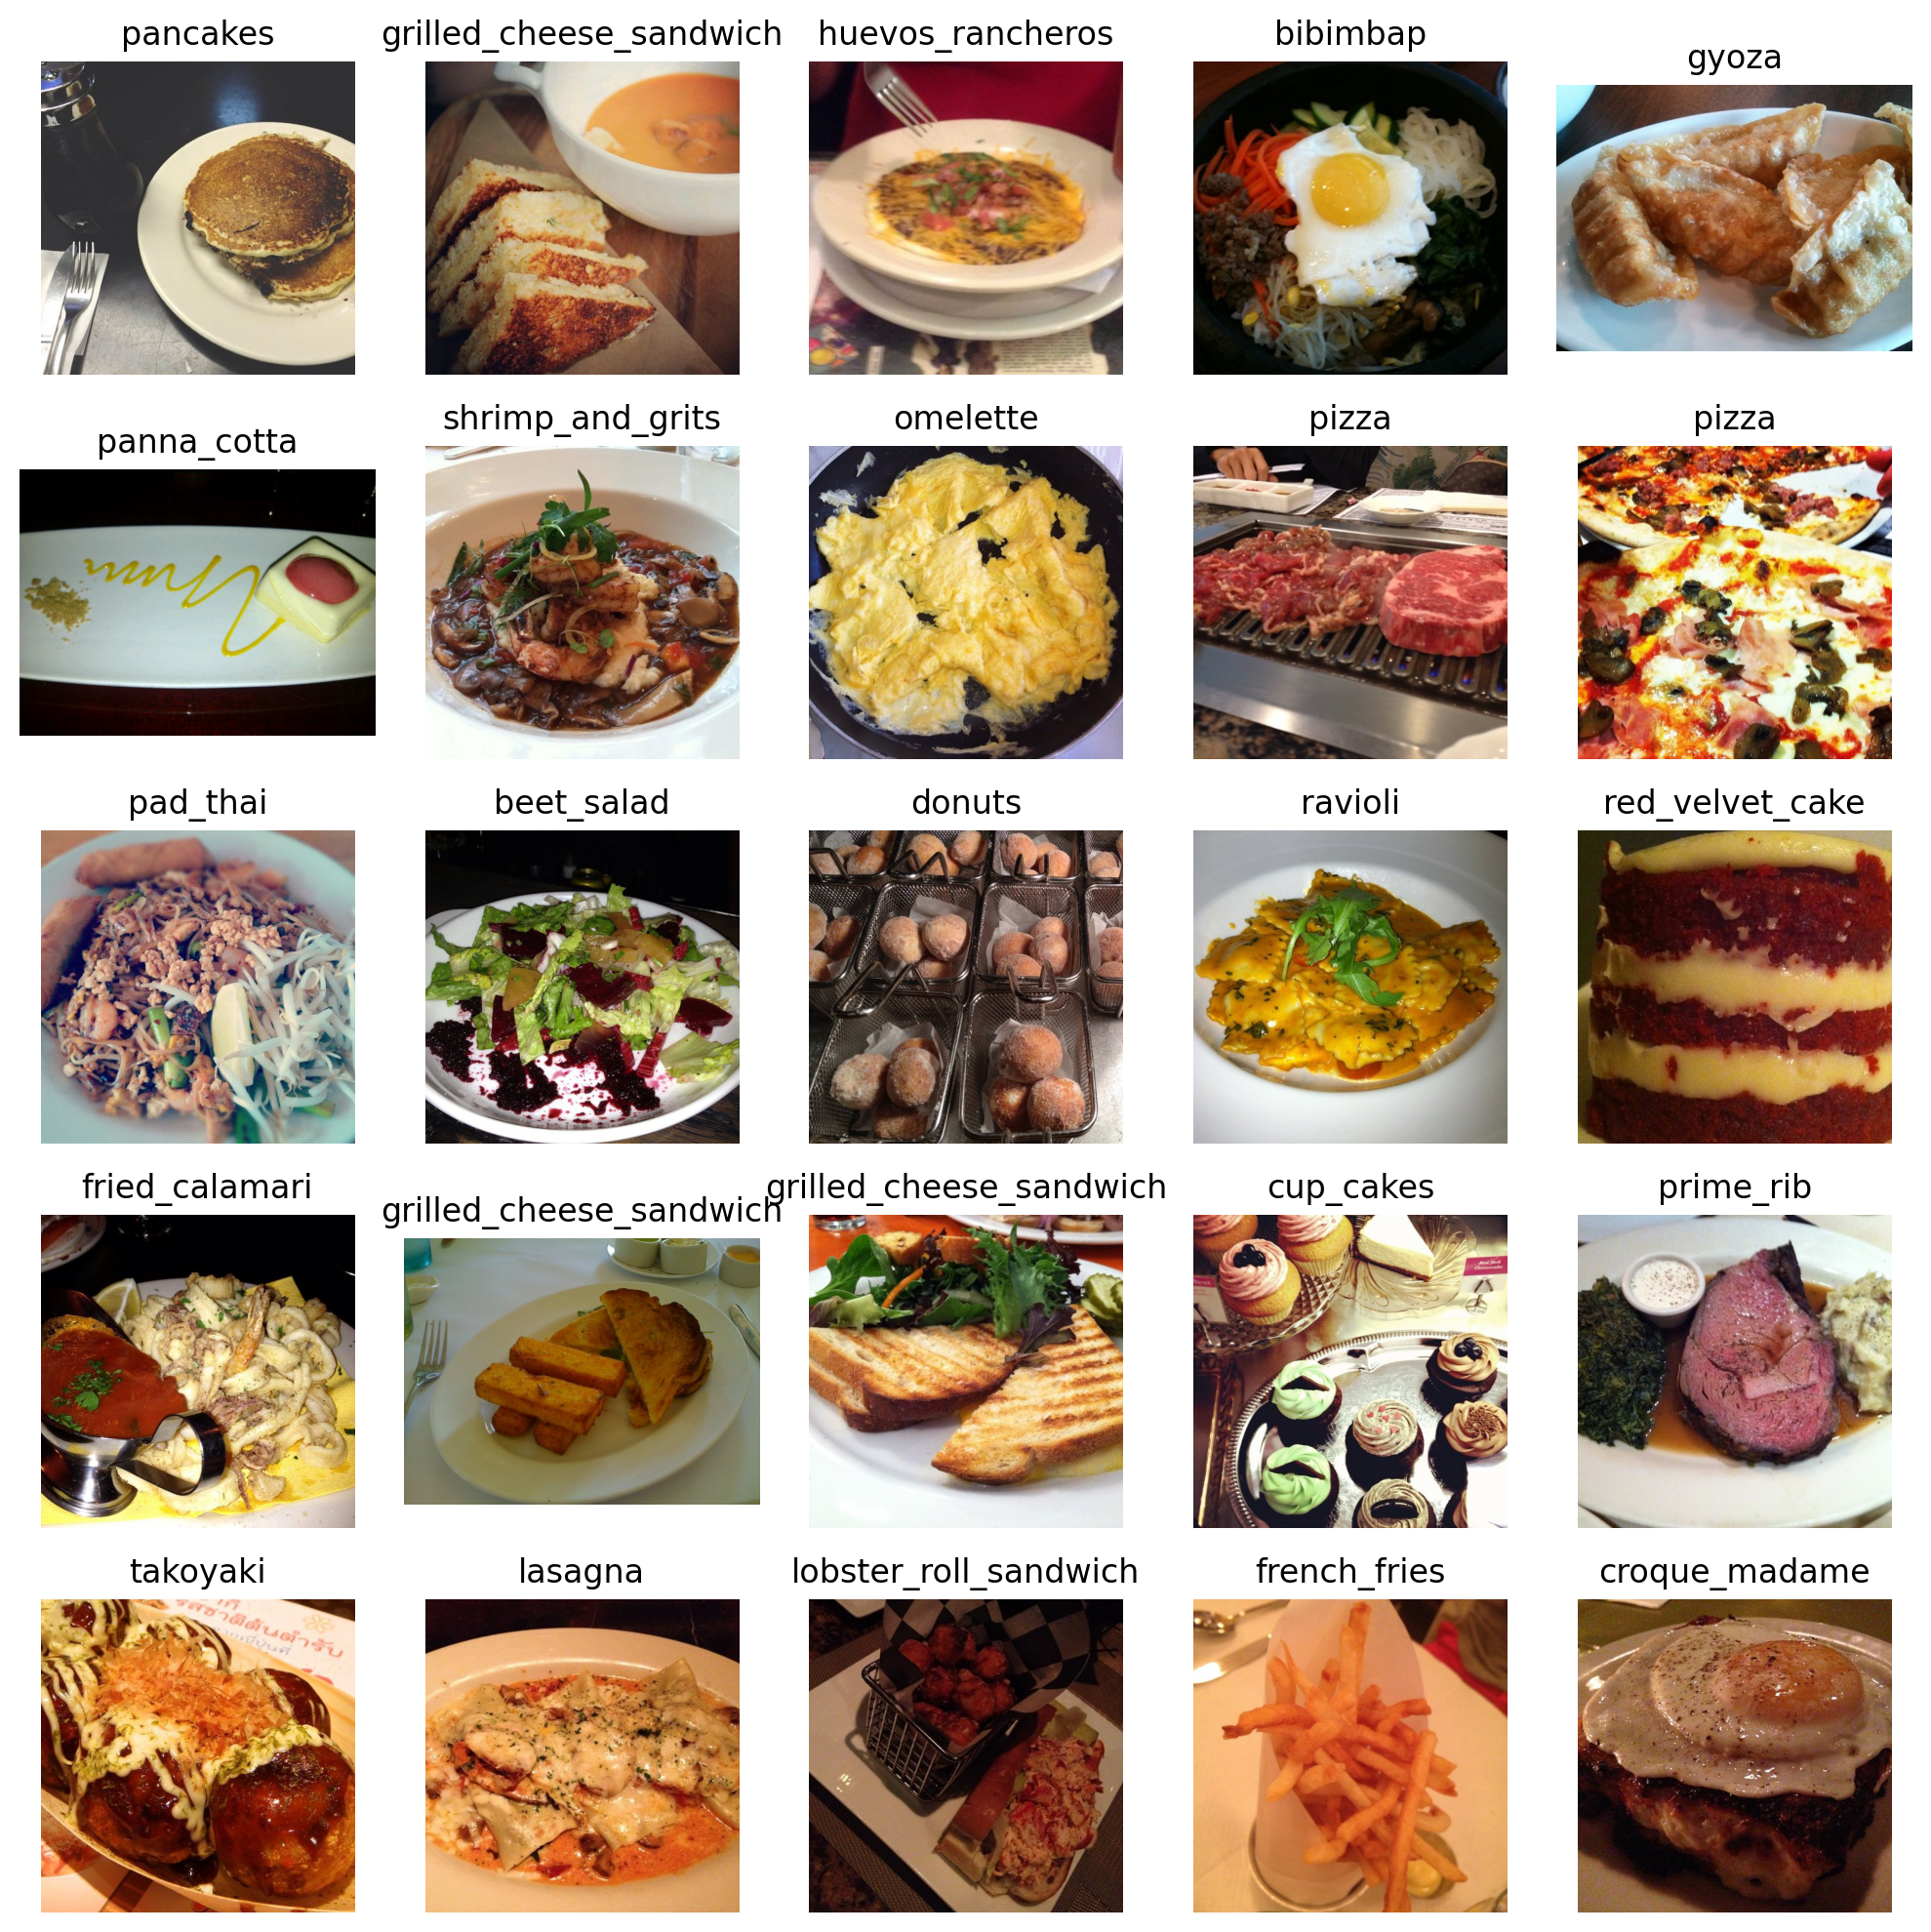

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10), dpi=200)

nrows, ncols = 5, 5


for i in range(nrows*ncols):
    # Set running seed for reproducible image generation
    np.random.seed(i)
    random_idx = np.random.randint(0, train_imgs.shape[0])
    img = plt.imread(train_imgs.path.iloc[random_idx])

    label = train_imgs["label"].iloc[random_idx]

    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(img)
    ax.set_title(label)
    plt.axis("off")

plt.tight_layout()

In [20]:
class Food101Dataset(Dataset):
    def __init__(self, data:pd.DataFrame, labels:dict, transform=None):
        """
        """
        self.data = data
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        img_path = self.data["path"].iloc[idx]
        img = Image.open(img_path)
        
        img = img.convert("RGB") if img.mode != 'RGB' else img
        
        label = self.labels.get(self.data["label"].iloc[idx])
        
        if self.transform:
            img = self.transform(img)
            
        return img, label

# [4] Data splitting and DataLoader setups

In [21]:
data_train_sample = Food101Dataset(train_imgs_sample, transform=transform, labels=labels)
data_test_sample = Food101Dataset(test_imgs_sample, transform=transform, labels=labels)

In [22]:
for i in range(5):
    image = data_train_sample.__getitem__(i)
    print(type(image[0]))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [23]:
print(len(data_train_sample))
print(len(data_test_sample))

7575
2525


In [24]:
train_size_sample = int(0.7 * len(data_train_sample))
val_size_sample = len(data_train_sample) - train_size_sample

data_train_sample, data_val_sample = random_split(data_train_sample, [train_size_sample, val_size_sample])

In [25]:
print(f"Dataset size:\n-------------\n\
Train:\t{len(data_train_sample)} \nVal:\t{len(data_val_sample)} \n\
Test:\t{len(data_test_sample)}")

Dataset size:
-------------
Train:	5302 
Val:	2273 
Test:	2525


In [26]:
# Preset batch size, number of epochs, learning rate
batch_size = 128
epochs = 300
lr = 1e-4

In [27]:
loader_train_sample = DataLoader(data_train_sample, batch_size=batch_size, shuffle=True)
loader_val_sample = DataLoader(data_val_sample, batch_size=batch_size, shuffle=False)
loader_test_sample = DataLoader(data_test_sample, batch_size=batch_size, shuffle=False)

# [5] Transfer Learning: Training and Validation

## [5.1] Define helpers, training functions, device, loss function, optimiser

The early stopping validator, model saver, trainer and plotter functions are taken from my previous work in Assignment 1, with small tweaks to be compatible with the new models.

In [28]:
def freeze(model):
    """
    Freezes all parameters of the model, i.e. disables gradients.
    """
    for p in model.parameters():
        p.requires_grad = False

In [29]:
class EarlyStoppingValidator(object):
    """
    A custom validator class for early stopping conditions. It sets the threshold for
    early stopping of network training based on the divergence between training loss 
    and validation loss.
    
    If validation loss is greater than the current minimum validation loss plus some
    threshold for a period of time exceeding the "patience" level, the training loop
    should break.
    """
    def __init__(self, patience, delta):
        self.patience = patience
        self.delta = delta
        self.min_val_loss = np.inf
        self.counter = 0
        
    def early_stop(self, val_loss):
        """
        Validate the early stopping conditions based on the observed validation loss.
        """
        if val_loss < self.min_val_loss:  # Keeps track of the minimum validation loss
            self.min_val_loss = val_loss
            self.counter = 0  # reset the counter
        elif val_loss >= self.min_val_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [30]:
# Create a checkpoints folder if not exists, to store best models
if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')
    

class ModelSaver(object):
    """
    Saves model weights every epoch as long as the validation loss decreases.
    
    As a new version is saved, all old versions are deleted, thus saves storage.
    
    """
    def __init__(self, model):
        self.model = model
        self.min_val_loss = np.inf
        self.epochs = []

    def save(self, epoch_num, val_loss):
        if val_loss < self.min_val_loss:  # Keeps track of the minimum validation loss
            self.min_val_loss = val_loss
            self.epochs.append(epoch_num)
            torch.save(self.model.state_dict(), f'./checkpoints/{self.model.__class__.__name__}_Epoch{epoch_num}.pt')
            if len(self.epochs) >= 2:
                os.remove(f'./checkpoints/{self.model.__class__.__name__}_Epoch{self.epochs[-2]}.pt')


In [31]:
def train_model(model: nn.Module, loss_fn, optimizer, scheduler, device: str,
                dataloader_train: DataLoader, dataloader_val: DataLoader, 
                epochs:int, early_stop_delta: float=1e-4) -> list:
    
    # Initialise the early stopper and model saver
    earlystop = EarlyStoppingValidator(patience=10, delta=early_stop_delta)
    modelsaver = ModelSaver(model)
    
    train_loss_list, val_loss_list = [], []
    training_start_time = time.time()
    
    for epoch in range(epochs):
        # Initialise the running totals for loss
        epoch_train_loss, epoch_val_loss = 0.0, 0.0
        
        # Set the model to training mode
        model.train()
        for train_x, train_y in dataloader_train:
            # Move data and target to the same device as the model
            train_x = train_x.to(device)
            train_y = train_y.to(device)
            
            # Set zero gradients
            optimizer.zero_grad()

            # Forward Propagation to get predicted outcome
            train_pred_y = model(train_x)

            # Compute the training loss
            train_loss = loss_fn(train_pred_y, train_y)

            # Back propagation
            train_loss.backward()

            # Update the weights
            optimizer.step()
            
            # Add the batch loss to the running epoch loss total
            epoch_train_loss += train_loss.item()
        
        # Set the model to evaluation mode
        model.eval()
        with torch.no_grad():
            for val_x, val_y in dataloader_val:    
                # Move data and target to the same device as the model
                val_x = val_x.to(device)
                val_y = val_y.to(device)
                
                # Propagate forward to get validation predictions
                val_pred_y = model(val_x)
                
                # Compute the validation loss
                val_loss = loss_fn(val_pred_y, val_y)
                
                # Add the batch loss to the running epoch loss total
                epoch_val_loss += val_loss.item()

        # Normalise the epoch loss running total by the number of batches in each set
        epoch_train_loss /= len(dataloader_train)
        epoch_val_loss /= len(dataloader_val)
        
        # Let the scheduler evaluate epoch validation loss
        scheduler.step(epoch_val_loss)
        
        # Add epoch results to lists for storing
        train_loss_list.append(epoch_train_loss)
        val_loss_list.append(epoch_val_loss)
        
        # Print results
        if (epoch+1 == 1) or ((epoch+1) % 10 == 0):
            epoch_end_time = time.time()
            epoch_elapsed = epoch_end_time - training_start_time
            print(f"EPOCH \t[{epoch+1}/{epochs}] \tTrain Loss {epoch_train_loss:.4f} \tVal Loss {epoch_val_loss:.4f} \t Elapsed time {epoch_elapsed//60:.0f}m {epoch_elapsed%60:.0f}s")
            
        # Save model if validation loss decreases
        modelsaver.save(epoch, epoch_val_loss)
        
        # Evaluate early stopping conditions
        if earlystop.early_stop(epoch_val_loss):
            break
    
    training_end_time = time.time()
    time_elapsed = training_end_time - training_start_time
    
    print(f'==============================================\nTraining completed in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s.')
        
    return train_loss_list, val_loss_list


In [32]:
def print_stats(model, val_loss_list):
    """
    Prints training statistics.
    """
    min_val_loss_idx = np.argmin(val_loss_list)
    print(f"{model.__class__.__name__}: Total epochs trained: \
{len(val_loss_list)}, Best epoch: {min_val_loss_idx}, Validation Loss: \
{val_loss_list[min_val_loss_idx]}")

In [33]:
# Statically choose the loss as categorical cross entropy
loss_fn = nn.CrossEntropyLoss()

# Choose the device
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'


# Define a function that returns the Adam optimiser for a model
def get_optim(model, lr):
    """
    Statically sets the Adam optimiser for the model, with the
    specified learning rate.
    """
    optimiser = optim.Adam(model.parameters(), lr=lr)
    return optimiser


print(f"Loss function: \t{loss_fn}\n\
Device used: \t{device}")

Loss function: 	CrossEntropyLoss()
Device used: 	mps


Since I'm training complex models with long training times, the general strategy to reduce computations while being fair in model comparison is to:
- Replace the model head with global average pooling and 3 linear layers, where:
    - The first linear layer's dimension matches that of the existing linear layer in the model,
    - The second linear layer's dimension is half that of the first linear layer,
    - The final linear layer maps to the length of the output layer, which is 101 classes.

- All activations/dropout layers in the head, where available, will be respected. Where not available, ReLU will be used because it is the most simple nonlinearity.

- Not run more than 1 experiment in this choosing phase. This means that more experiments will only be run once the best performing model among the three has been found, where the performance metric is the validation loss.

## [5.2] Inception-ResnetV2

In [34]:
# Freeze Inception-ResnetV2's gradients
freeze(irv2)

For Inception-ResnetV2, the model head refers to the following layers:
- `global_pool`: which is a `SelectAdaptivePool2d` with `avg` pooling
- `head_drop`: which is a dropout layer for the model head
- `classif`: which is the linear layer responsible for classifying the output in the model head

Since the global average pooling is already implemented (see source code: https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/inception_resnet_v2.py), and the dropout is an identity, I will only replace the fully connected layer `classif` with the appropriate dimension.

In [37]:
irv2.classif = nn.Sequential(
    nn.Linear(in_features=1536, out_features=1000, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=1000, out_features=500, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=500, out_features=len(labels), bias=True)
)

In [39]:
optim_irv2 = get_optim(irv2, lr)
lr_scheduler_irv2 = ReduceLROnPlateau(optim_irv2, mode='min', factor=0.1, patience=3, min_lr=1e-6)

train_loss_irv2, val_loss_irv2 = train_model(model=irv2, loss_fn=loss_fn, optimizer=optim_irv2, 
                                             scheduler=lr_scheduler_irv2, device=device, 
                                             dataloader_train=loader_train_sample, 
                                             dataloader_val=loader_val_sample, 
                                             epochs=epochs)

EPOCH 	[1/300] 	Train Loss 4.6006 	Val Loss 4.5767 	 Elapsed time 11m 53s
EPOCH 	[10/300] 	Train Loss 2.9612 	Val Loss 3.2488 	 Elapsed time 108m 53s
EPOCH 	[20/300] 	Train Loss 2.2266 	Val Loss 2.9993 	 Elapsed time 217m 27s
EPOCH 	[30/300] 	Train Loss 1.7762 	Val Loss 2.8890 	 Elapsed time 323m 1s
EPOCH 	[40/300] 	Train Loss 1.7173 	Val Loss 2.8825 	 Elapsed time 438m 28s
EPOCH 	[50/300] 	Train Loss 1.7044 	Val Loss 2.8843 	 Elapsed time 556m 41s
Training completed in 567m 19s.


## [5.3] MobileNetV3

In [40]:
freeze(mobilenetv3)

For MobileNetV3, since the global average pooling layer is already in place, I will only update the classifier. Since the original architecture has a hard-swish activation function and dropout layer in between linear layers, I will respect that in this construction.

In [42]:
mobilenetv3.classifier = nn.Sequential(
    nn.Linear(in_features=960, out_features=1280, bias=True),  # Same as the first linear layer in the original model
    nn.Hardswish(),  # Same activation
    nn.Dropout(p=0.2, inplace=True),  # Same dropout with rate
    nn.Linear(in_features=1280, out_features=640, bias=True),  # Half the neurons
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=640, out_features=len(labels), bias=True)
)

In [44]:
optim_mobilenetv3 = get_optim(mobilenetv3, lr)
lr_scheduler_mobilenetv3 = ReduceLROnPlateau(optim_mobilenetv3, mode='min', factor=0.1, patience=3, min_lr=1e-6)

train_loss_mobilenetv3, val_loss_mobilenetv3 = train_model(model=mobilenetv3, 
                                                           loss_fn=loss_fn, 
                                                           optimizer=optim_mobilenetv3, 
                                                           scheduler=lr_scheduler_mobilenetv3,
                                                           device=device, 
                                                           dataloader_train=loader_train_sample, 
                                                           dataloader_val=loader_val_sample, 
                                                           epochs=epochs)

EPOCH 	[1/300] 	Train Loss 4.5933 	Val Loss 4.5611 	 Elapsed time 3m 0s
EPOCH 	[10/300] 	Train Loss 2.3796 	Val Loss 2.6232 	 Elapsed time 30m 1s
EPOCH 	[20/300] 	Train Loss 1.7090 	Val Loss 2.4130 	 Elapsed time 59m 44s
EPOCH 	[30/300] 	Train Loss 1.3261 	Val Loss 2.3629 	 Elapsed time 89m 18s
EPOCH 	[40/300] 	Train Loss 1.0979 	Val Loss 2.3366 	 Elapsed time 118m 43s
Training completed in 143m 13s.


## [5.4] NASNet

In [45]:
freeze(nasnet)

Since NASNet also has a global average pooling layer already, I will only implement a different classifier.

In [47]:
nasnet.last_linear = nn.Sequential(
    nn.Linear(in_features=4032, out_features=1000, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=1000, out_features=500, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=500, out_features=len(labels), bias=True)
)

In [49]:
optim_nasnet = get_optim(nasnet, lr)
lr_scheduler_nasnet = ReduceLROnPlateau(optim_nasnet, mode='min', factor=0.1, patience=3, min_lr=1e-6)

train_loss_nasnet, val_loss_nasnet = train_model(model=nasnet, loss_fn=loss_fn, 
                                                 optimizer=optim_nasnet, 
                                                 scheduler=lr_scheduler_nasnet,
                                                 device=device, 
                                                 dataloader_train=loader_train_sample, 
                                                 dataloader_val=loader_val_sample, 
                                                 epochs=epochs)

EPOCH 	[1/300] 	Train Loss 4.5698 	Val Loss 4.4952 	 Elapsed time 30m 47s
EPOCH 	[10/300] 	Train Loss 2.1973 	Val Loss 2.9441 	 Elapsed time 296m 33s
EPOCH 	[20/300] 	Train Loss 1.2432 	Val Loss 2.8082 	 Elapsed time 586m 54s
EPOCH 	[30/300] 	Train Loss 1.1720 	Val Loss 2.8064 	 Elapsed time 882m 11s
EPOCH 	[40/300] 	Train Loss 1.1648 	Val Loss 2.8080 	 Elapsed time 1179m 51s
Training completed in 1269m 28s.


# [6] Model performance analysis

In the following cells, I print the statistics of model validation for each model, as well as plot their learning curves. All models start to overfit very early on, so the strict early stop delta of `1e-4` and a lenient patience of `10` (meaning: stop training if the validation loss does not improve by at least `1e-4` compared to the best available validation loss in `10` epochs) definitely helped to reduce training time.

In [50]:
print_stats(irv2, val_loss_irv2)

InceptionResnetV2: Total epochs trained: 51, Best epoch: 40, Validation Loss: 2.871871484650506


In [51]:
print_stats(mobilenetv3, val_loss_mobilenetv3)

MobileNetV3: Total epochs trained: 48, Best epoch: 37, Validation Loss: 2.332803421550327


In [52]:
print_stats(nasnet, val_loss_nasnet)

NASNetALarge: Total epochs trained: 43, Best epoch: 32, Validation Loss: 2.7967074844572277


In [62]:
def plot_learning_curves(model: nn.Module, train_loss: list, val_loss: list, epochs: int) -> None:
    """
    Plots the learning curve of the model
    """
    plt.plot(range(epochs), train_loss, label='Training Loss')
    plt.plot(range(epochs), val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model.__class__.__name__} learning curve', weight='bold')
    plt.legend()


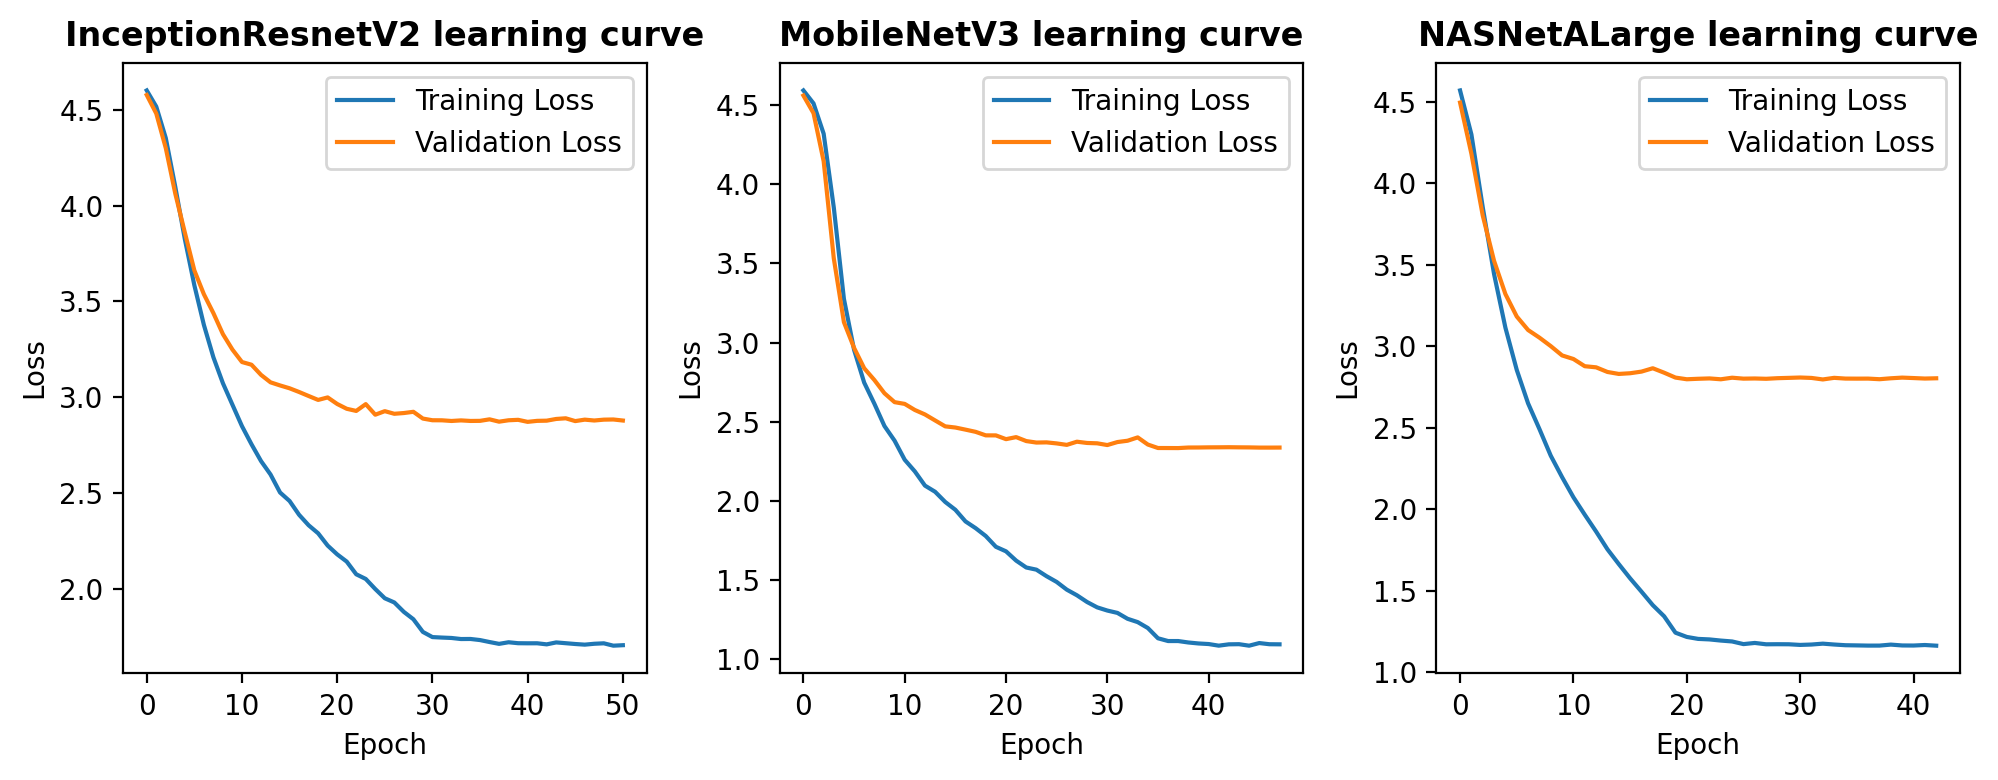

In [68]:
all_models = [irv2, mobilenetv3, nasnet]
all_train_losses = [train_loss_irv2, train_loss_mobilenetv3, train_loss_nasnet]
all_val_losses = [val_loss_irv2, val_loss_mobilenetv3, val_loss_nasnet]


rows, cols = 1, 3
fig = plt.figure(figsize=(10, 4), dpi=200)

for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    plot_learning_curves(all_models[i], all_train_losses[i], all_val_losses[i], len(all_val_losses[i]))
    
fig.tight_layout()

MobileNetV3 turns out to be the winner in validation. I will now get its accuracy on the small test sample.

## Winning model for Part A: MobileNetV3

In [56]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [57]:
def eval_model(model: nn.Module, device: str, dataloader: DataLoader, return_conf_matx=False):
    """
    Evaluates the best model on a given dataset.
    
    """
    model.eval()
    y_true_concat, y_pred_concat = torch.LongTensor(), torch.LongTensor()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            y_pred = model(X)
            y_pred = torch.argmax(y_pred, dim=1)
            y_true_concat = torch.cat((y_true_concat, y))
            y_pred_concat = torch.cat((y_pred_concat, y_pred))
    
    acc_score = accuracy_score(y_true_concat, y_pred_concat)
    
    if return_conf_matx:
        conf_matx = confusion_matrix(y_true_concat, y_pred_concat)
        return acc_score, conf_matx
    return acc_score

In [58]:
mobilenetv3_acc, mobilenetv3_conf_matx = eval_model(model=mobilenetv3, device=device, 
                                                    dataloader=loader_test_sample, 
                                                    return_conf_matx=True)

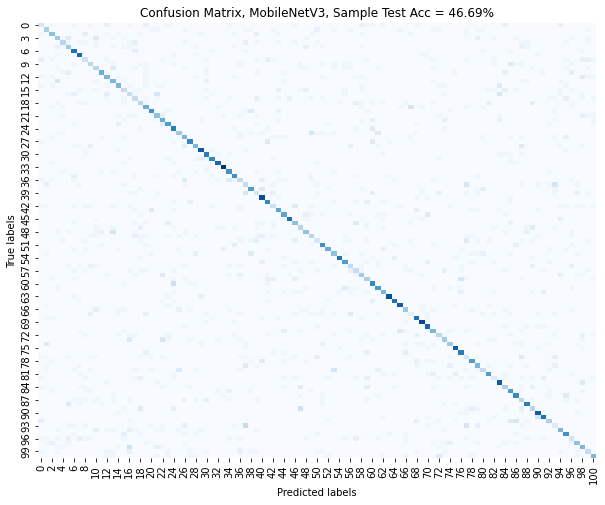

In [59]:
import seaborn as sns

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(mobilenetv3_conf_matx, annot=False, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix, {mobilenetv3.__class__.__name__}, Sample Test Acc = {mobilenetv3_acc*100:.2f}%')
plt.show()

Performance is subpar, since I only trained the model on 10% of the dataset in order to choose a winner. This is also the reason why the model's validation loss did not improve towards the later half of training. The next part on fine-tuning is expected to reduce the validation loss, hence improving test accuracy on the full dataset.